In [27]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, RidgeCV, PoissonRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.stattools import adfuller

# options to display columns
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [28]:
# read data
bikes = pd.read_csv('data/finaldata.csv')

In [29]:
bikes.head()

,date,numbikes,log_numbikes,year,month,week,day,dayofweek,dayofyear,sin_doy,cos_doy,sin_dow,cos_dow,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,holiday,awnd,prcp,snow,snwd,tmax,tmin,awnd_log,prcp_log,snow_log,snwd_log
0,2011-01-01,959,6.865891,2011,1,52,1,5,1,0.017213,0.999852,-0.974928,-0.222521,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.2,0.3,0.0,0.0,14.4,1.1,1.435085,0.262364,0.0,0.0
1,2011-01-02,781,6.660575,2011,1,52,2,6,2,0.034422,0.999407,-0.781831,0.623490,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.9,1.5,0.0,0.0,15.0,1.1,1.774952,0.916291,0.0,0.0
2,2011-01-03,1301,7.170888,2011,1,1,3,0,3,0.051620,0.998667,0.000000,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.6,0.0,0.0,0.0,5.0,-2.2,1.722767,0.000000,0.0,0.0
3,2011-01-04,1536,7.336937,2011,1,1,4,1,4,0.068802,0.997630,0.781831,0.623490,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.9,0.0,0.0,0.0,6.1,-3.9,1.360977,0.000000,0.0,0.0
4,2011-01-05,1571,7.359468,2011,1,1,5,2,5,0.085965,0.996298,0.974928,-0.222521,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.8,0.0,0.0,0.0,6.1,-0.6,1.568616,0.000000,0.0,0.0


In [30]:
# define list of features for regression analysis
calendar_features = [f'dow_{i+1}' for i in range(0,6)] + \
                    [f'month_{i+1}' for i in range(1,12)] + \
                    [f'year_{i+1}' for i in range(2011,2018)] + \
                    ['sin_doy', 'cos_doy', 'sin_dow', 'cos_dow', 'holiday']
weather_features = ['awnd_log', 'prcp_log', 'snow_log',	'snwd_log', 'tmax', 'tmin']

In [31]:
# define function to 
from sklearn.ensemble import RandomForestRegressor


def reg_predict(
    df,
    features,
    train_year_end = 2018, # training year from 2011 up until year specified here
    test_year = 2019, # test year must be after train_year_end, must be between 2011 and 2019
    model = 'Linear', # choice of 'Linear', 'Polynomial', 'Ridge', 'Poisson'
    scaling = True, # default scaling (standardization) of x variables
    logbikes = False, # default y variable is not log transformed
    degree = 2, # quadratic polynomial is default for polynomial and ridge regression
    alphas = [0.01,0.1,1,10,100], # regularization grid for ridge regression
    n_estimators = 550,
    max_features = 'sqrt'
):

    ### regression analysis ###

    # define train/test years
    df_train = df[df['year'] <= train_year_end]
    df_test = df[df['year'] == test_year]

    # define X, y for train/test sample
    X_train = df_train[features]
    X_test = df_test[features]
    y_train = df_train['numbikes']
    y_test = df_test['numbikes']

    # scaling standardization for features
    if scaling:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    # log choice for number of bikes
    if logbikes:
        y_train = np.log(y_train)
        y_test = np.log(y_test)
    
    # choice for regression models
    if model == 'Linear':
        regr = LinearRegression()
    elif model == 'Polynomial':
        regr = make_pipeline(
            PolynomialFeatures(degree=degree),
            LinearRegression()
            )
    elif model == 'Ridge':
        regr = make_pipeline(
            PolynomialFeatures(degree=degree),
            RidgeCV(alphas=alphas)
            )
    elif model == 'Poisson':
        regr = PoissonRegressor()
    elif model == 'XGBoost':
        regr = XGBRegressor(n_estimators=n_estimators)
    elif model == 'Random Forest':
        regr = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features)
    else:
        assert False, f'Unknown model {model}'
    
    # fitting and prediction
    regr.fit(X_train, y_train)
    y_pred_train = regr.predict(X_train)
    y_pred = regr.predict(X_test)

    # print mape for train/test of model
    print('----------------------------------')
    print(f'{model} regression')
    print(f'Training Period: 2011-{train_year_end}')
    print(f'Test Period: {test_year}')
    print('----------------------------------')
    print(f'Train MAPE: {mean_absolute_percentage_error(y_train, y_pred_train).round(3)}')
    print(f'Test MAPE: {mean_absolute_percentage_error(y_test, y_pred).round(3)}')
    print('----------------------------------')

    ### residuals analysis ###

    # define residuals and subplots
    residuals_test = y_test - y_pred
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    fig.suptitle(f'Residual Analysis: Test Period {test_year}', fontsize=12)

    # plot distribution of residuals
    plot_0 = sns.histplot(residuals_test, ax=ax[0], color='Blue')
    plot_0.grid(False)
    ax[0].set_xlabel('Residuals', fontsize=10)
    ax[0].set_ylabel('')
    
    # plot residuals vs predicted
    plot_1 = sns.scatterplot(x=y_pred, y=residuals_test, ax=ax[1], color='Blue')
    plot_1.grid(False)
    ax[1].set_xlabel('Predicted', fontsize=10)
    ax[1].set_ylabel('Residual', fontsize=10)
    
    # augmented dickey-fuller test for stationarity of residuals #
    print('ADF Test for Residual Stationarity')
    result = adfuller(residuals_test)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
	    print('\t%s: %.3f' % (key, value))
    print('----------------------------------')

----------------------------------
Linear regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.474
Test MAPE: 0.693
----------------------------------
ADF Test for Residual Stationarity
ADF Statistic: -2.583763
p-value: 0.096400
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


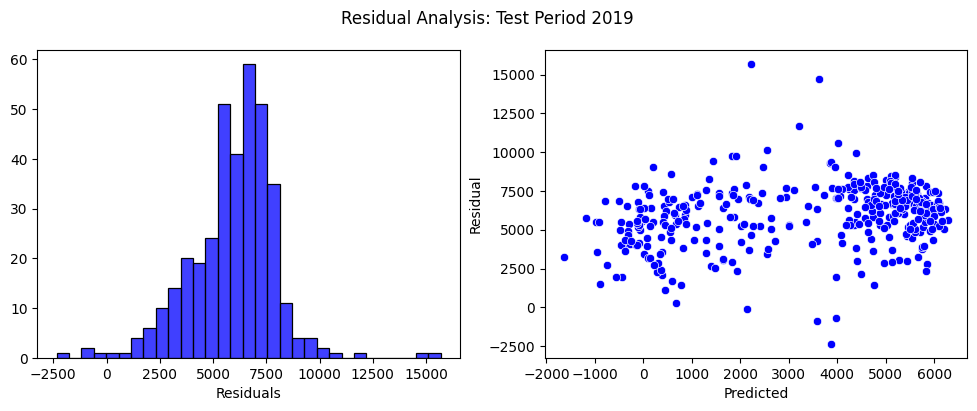

In [32]:
# baseline model 
reg_predict(df=bikes, features=calendar_features)

----------------------------------
Linear regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.029
Test MAPE: 0.115
----------------------------------
ADF Test for Residual Stationarity
ADF Statistic: -14.514037
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
----------------------------------


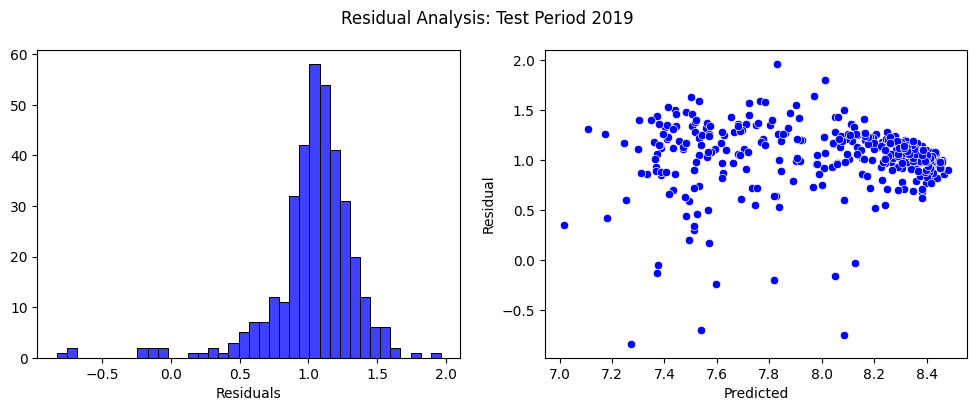

In [33]:
# use logbikes on baseline model
reg_predict(df=bikes, features=calendar_features, logbikes=True)

----------------------------------
Polynomial regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.025
Test MAPE: 0.116
----------------------------------
ADF Test for Residual Stationarity
ADF Statistic: -4.160854
p-value: 0.000767
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


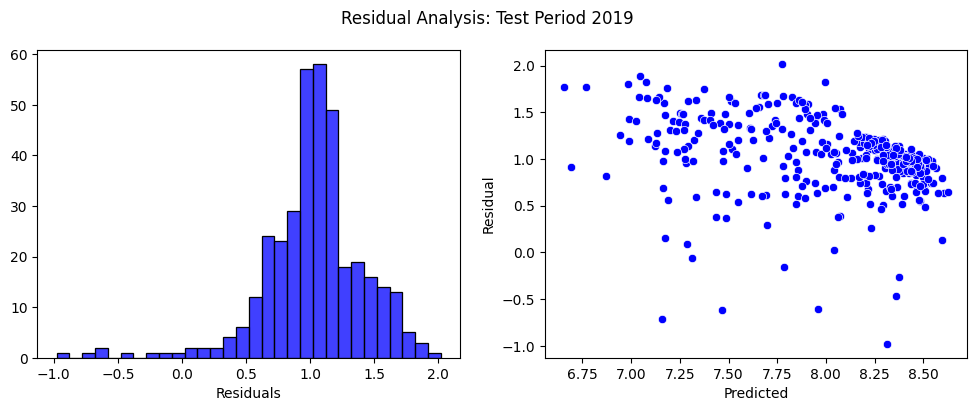

In [34]:
# use logbikes and polynomial regression degree 2
reg_predict(df=bikes, features=calendar_features, logbikes=True, model='Polynomial')

----------------------------------
Ridge regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.025
Test MAPE: 0.116
----------------------------------
ADF Test for Residual Stationarity
ADF Statistic: -3.487229
p-value: 0.008321
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


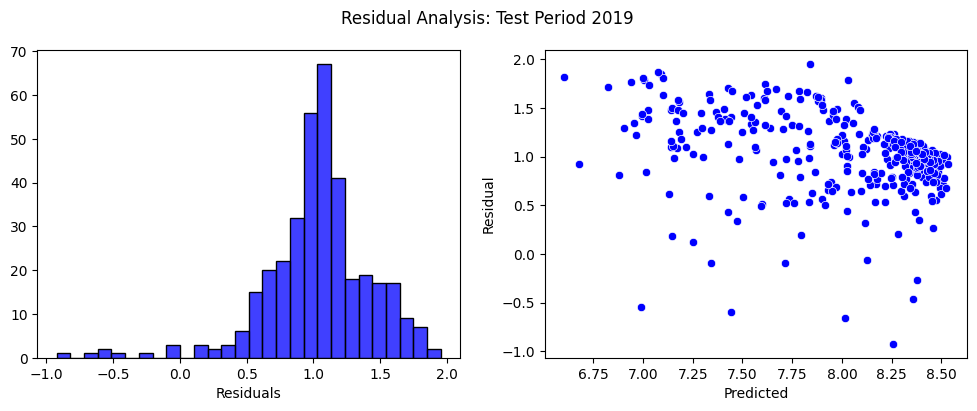

In [35]:
# use logbikes and ridge regression
reg_predict(df=bikes, features=calendar_features, logbikes=True, model='Ridge')

----------------------------------
Poisson regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.033
Test MAPE: 0.08
----------------------------------
ADF Test for Residual Stationarity
ADF Statistic: -3.923940
p-value: 0.001866
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


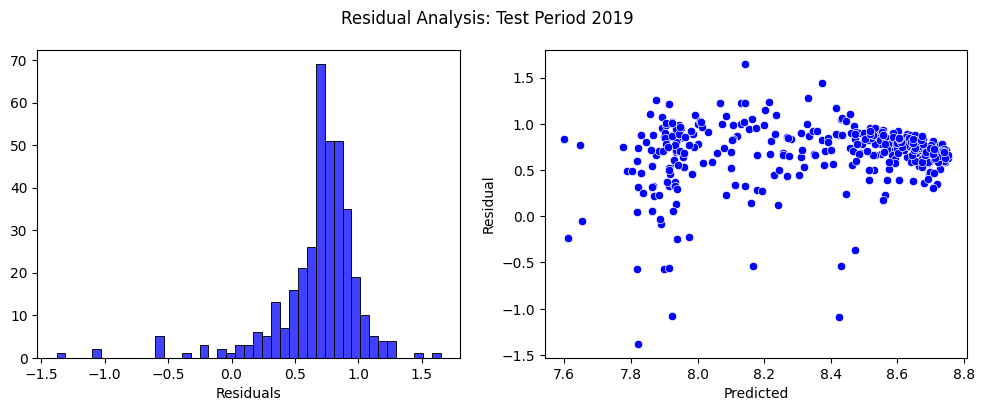

In [36]:
# use logbikes and poisson regression
reg_predict(df=bikes, features=calendar_features, logbikes=True, model='Poisson')

In [37]:
# include weather and calendar features
features = [*calendar_features, *weather_features]

----------------------------------
Linear regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.021
Test MAPE: 0.114
----------------------------------
ADF Test for Residual Stationarity
ADF Statistic: -9.554721
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
----------------------------------


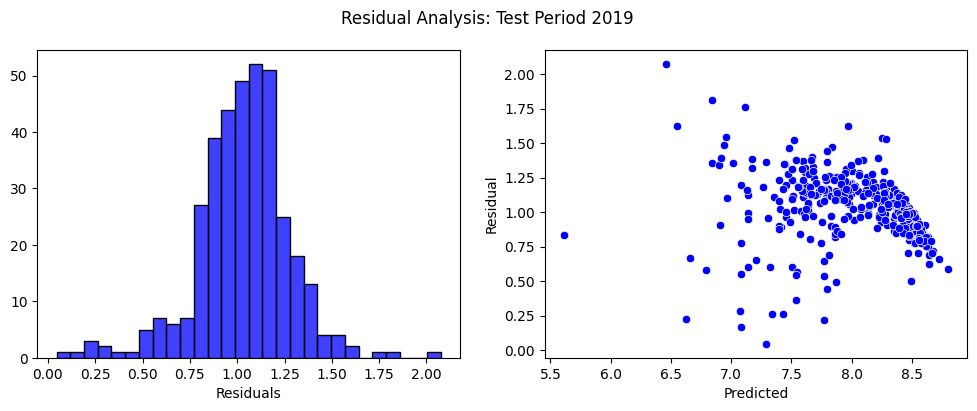

In [38]:
# use logbike with weather and calendar features
reg_predict(df=bikes, features=features, logbikes=True)

----------------------------------
Poisson regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.025
Test MAPE: 0.076
----------------------------------
ADF Test for Residual Stationarity
ADF Statistic: -8.460738
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


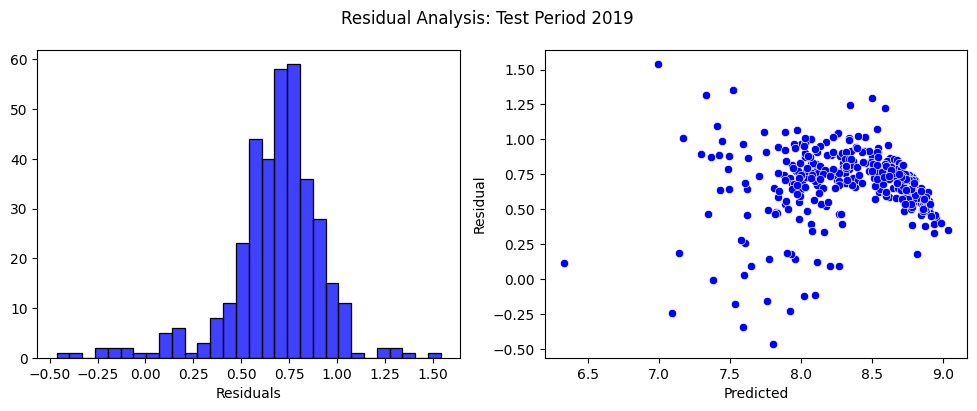

In [39]:
# use logbike with weather and calendar features; poisson regression
reg_predict(df=bikes, features=features, logbikes=True, model='Poisson')

----------------------------------
XGBoost regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.0
Test MAPE: 0.105
----------------------------------
ADF Test for Residual Stationarity
ADF Statistic: -1.986800
p-value: 0.292390
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


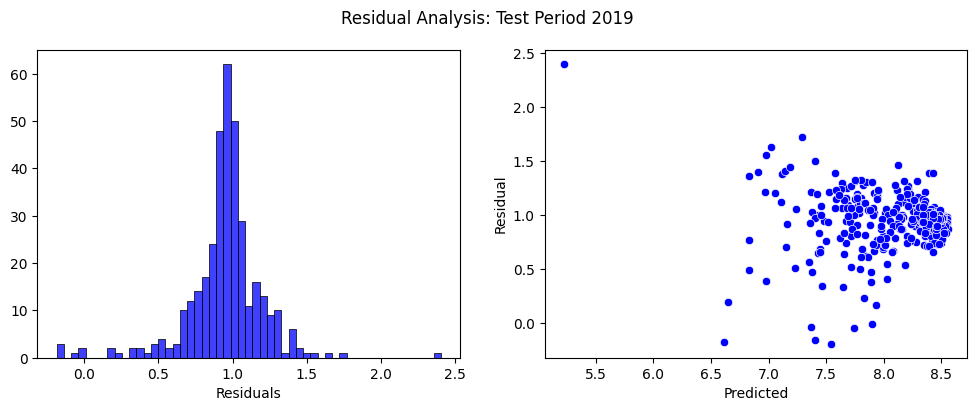

In [40]:
reg_predict(df=bikes, features=features, model='XGBoost', logbikes=True)

----------------------------------
Random Forest regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.01
Test MAPE: 0.056
----------------------------------
ADF Test for Residual Stationarity
ADF Statistic: -2.773288
p-value: 0.062192
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


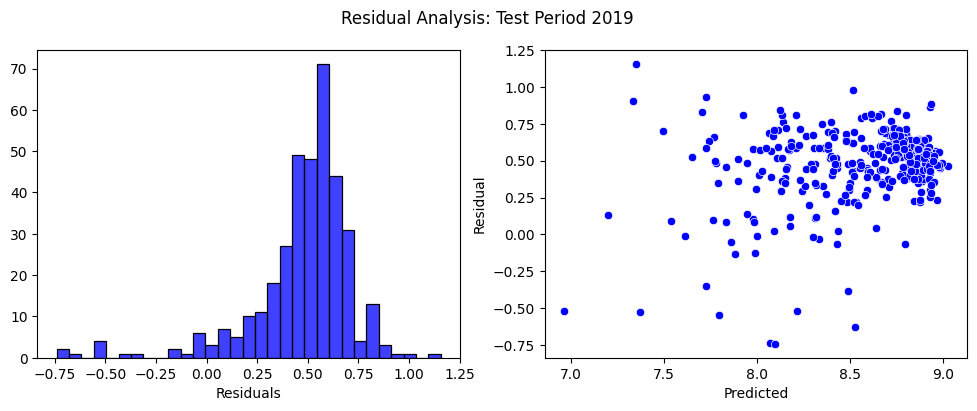

In [41]:
reg_predict(df=bikes, features=features, model='Random Forest', logbikes=True)